In [63]:
import numpy as np 
import pandas as pd

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pprint import pprint
from datetime import datetime
import collections
import re

In [65]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jasmine_ranpise\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jasmine_ranpise\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jasmine_ranpise\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [66]:
import os
from os import path
from wordcloud import WordCloud

In [67]:
# import tweet file

file_name = 'D:/ntu/6312/wordcloud/tweets_sentiment.csv'
data = pd.read_csv(file_name, sep=';').set_index('id')
data.shape

(5000, 3)

In [68]:
# check data

data.head()

,created_at,text,sentiment
id,,,
77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


In [69]:
# view unprocessed tweets sample
# raw data

for i in range(5):
    pprint(data.iat[i,1])

('RT @RobertBeadles: Yo💥\n'
 'Enter to WIN 1,000 Monarch Tokens✅\n'
 '\n'
 'US Stock Market Crashes &amp; what we can LEARN from them PT3!\n'
 '\n'
 'RETWEET, WATCH video…')
('#SriLanka surcharge on fuel removed!\n'
 '⛽📉\n'
 'The surcharge of Rs.26 imposed on diesel and petrol has been revoked with '
 'effect from midnight on June 23 says Power, Energy and Transport Minister '
 'Mahinda. Amaraweera -Adaderana-\n'
 '\n'
 '#lka #FuelPrices #taxes #economy #stocks #StockMarket')
('Net issuance increases to fund fiscal programs &gt; yields spike higher &gt; '
 'risk off: #stocks and #EMFX correct lower &gt; #Fed comes in with #YCC &gt; '
 'stocks to new all time highs with 20% unemployment and -25% GDP. Fin.')
("RT @bentboolean: How much of Amazon's traffic is served by Fastly? Help us "
 'find out by running this tool from your IP address: https://t.co…')
('$AMD Ryzen 4000 desktop CPUs looking ‘great’ and on track to launch in 2020 '
 'https://t.co/y7yYvXOVYJ #madtweets #stocks #cnbc #AMD

In [70]:
# tickr pattern match

tickr_pattern = re.compile(r'(^\$[A-Z]+|^\$ES_F)')

tickr_dictionary = collections.defaultdict(int)

for text in data['text']:
    for word in text.split():
        if tickr_pattern.fullmatch(word) is not None:
            tickr_dictionary[word[1:]] += 1

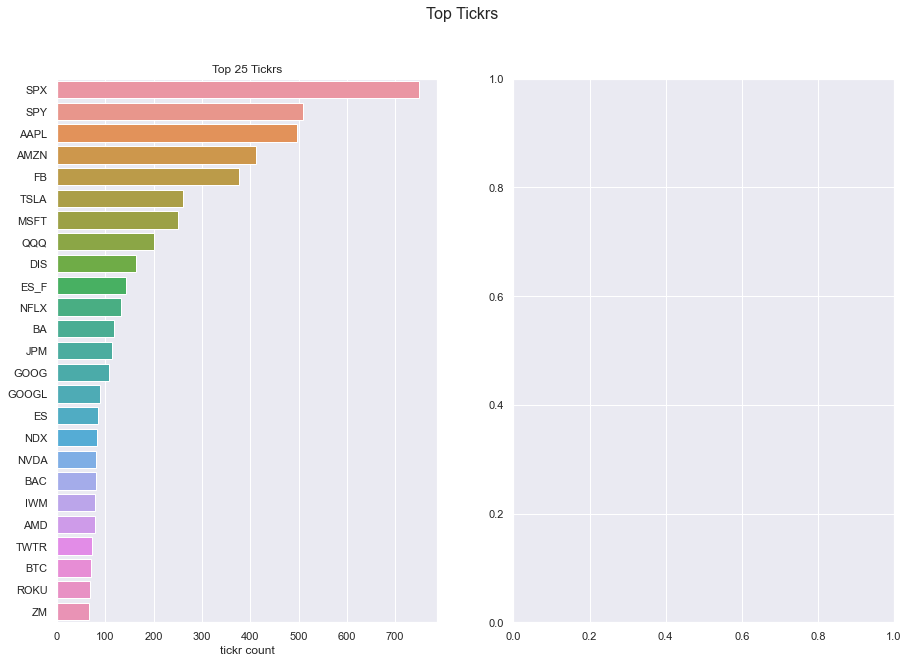

In [72]:
# top tickr list
# most talked stocks

tickr_dataframe = pd.DataFrame.from_dict(tickr_dictionary, orient='index').rename(columns={0:'tickr count'})\
.sort_values('tickr count', ascending=False).head(25)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
plt.suptitle('Top Tickrs', fontsize=16)

sns.barplot(x=tickr_dataframe['tickr count'], y=tickr_dataframe.index, orient='h', ax=ax[0])
ax[0].set_title('Top 25 Tickrs')

plt.show()

In [73]:
# preprocess word cloud
# delete unwanted emojis, urls, symbols etc etc
# clean data

character_compile = re.compile(r'[^a-zA-Z\s]')
usernamehandle_compile = re.compile(r'@\w+')
emoji_compile = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
url_compile = re.compile(
    'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
pics_compile = re.compile('pic\.twitter\.com/.{10}')
specialchar_compile = re.compile(r'(&amp;|&gt;|&lt;)')
tag_compile = re.compile(r'<.*?>')

STOPWORDS = set(stopwords.words('english')).union(
    {'rt', 'retweet', 'RT', 'Retweet', 'RETWEET'})

lemmatizer = WordNetLemmatizer()

def remove_tickr(phrase):
    return tickr_compile.sub('', phrase)
    
def specialchar(phrase):
    return specialchar_compile.sub(' ', phrase)

def emoji(phrase):
    return emoji_compile.sub(' ', phrase)

def url(phrase):
    return url_compile.sub('', phrase)

def pic(phrase):
    return pics_compile.sub('', phrase)

def html_tag(phrase):
    return tag_compile.sub(' ', phrase)

def usernamehandle(phrase):
    return username_compile.sub('', phrase)

def decontract(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # DIS, ticker symbol of Disney, is interpreted as the plural of "DI" in WordCloud, so convert to Disney
    
    phrase = re.sub('DIS', 'Disney', phrase)

    # general
    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"(he|He)\'s", "he is", phrase)
    phrase = re.sub(r"(she|She)\'s", "she is", phrase)
    phrase = re.sub(r"(it|It)\'s", "it is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"(\'ve|has)", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def character(phrase):
    return character_compile.sub('', phrase)

def remove_stopwords(phrase):
    return " ".join([word for word in str(phrase).split()\
                     if word not in STOPWORDS])

def tokenize_stem(phrase):   
    tokens = word_tokenize(phrase)
    stem_words =[]
    for token in tokens:
        word = lemmatizer.lemmatize(token)
        stem_words.append(word)        
    buf = ' '.join(stem_words)    
    return buf

In [74]:
# preprocess word cloud
# arrange text

def arrange_text(ds):
    ds['text2'] = ds['text'].apply(emoji)
    ds['text2'] = ds['text2'].apply(usernamehandle)
    ds['text2'] = ds['text2'].apply(specialchar)
    ds['text2'] = ds['text2'].apply(url)
    ds['text2'] = ds['text2'].apply(pic)
    ds['text2'] = ds['text2'].apply(html_tag)
    ds['text2'] = ds['text2'].apply(decontract)
    ds['text2'] = ds['text2'].apply(character)
    ds['text2'] = ds['text2'].apply(tokenize_stem)
    ds['text2'] = ds['text2'].apply(remove_stopwords)

In [75]:
arrange_text(data)

In [76]:
# view processed tweets sample
# clean data

for i in range(5):
    pprint(data.iat[i,3])

'Yo Enter WIN Monarch Tokens US Stock Market Crashes LEARN PT WATCH video'
('SriLanka surcharge fuel removed The surcharge Rs imposed diesel petrol '
 'revoked effect midnight June say Power Energy Transport Minister Mahinda '
 'Amaraweera Adaderana lka FuelPrices tax economy stock StockMarket')
('Net issuance increase fund fiscal program yield spike higher risk stock EMFX '
 'correct lower Fed come YCC stock new time high unemployment GDP Fin')
'How much Amazons traffic served Fastly Help u find running tool IP address'
'AMD Ryzen desktop CPUs looking great track launch madtweets stock cnbc AMD'


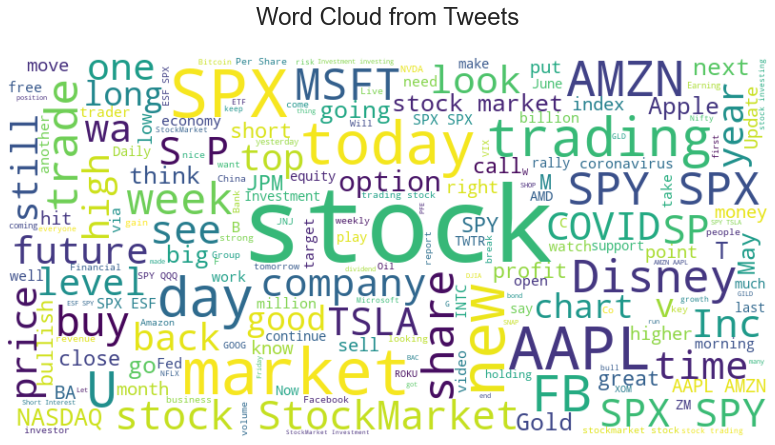

In [77]:
# tickr word cloud
# this gives the idea on most hot and talked about stocks in the market

words = ' '.join([text for text in data['text2']])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_font_size=110)\
        .generate(words)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud from Tweets\n', fontsize=24)
plt.axis('off')
plt.show()